In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [4]:
data_dir = "myData"
labels = pd.read_csv('labels.csv')

In [5]:
image_paths = []
image_labels = []

In [6]:
for folder in os.listdir('myData'):
    label = labels[labels['ClassId'] == int(folder)]['Name'].values[0]
    folder_path = os.path.join('myData', folder)

    # Bu klasördeki her resmi işaretle
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)

In [7]:
data_df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [8]:
data_df.tail()

,image_path,label
73134,myData\9\9_12355_1577672001.2420478.jpg,No passing
73135,myData\9\9_12356_1577672001.2430463.jpg,No passing
73136,myData\9\9_12357_1577672001.2440445.jpg,No passing
73137,myData\9\9_12358_1577672001.2440445.jpg,No passing
73138,myData\9\9_12359_1577672001.245041.jpg,No passing


In [9]:
label_counts = data_df['label'].value_counts()
label_counts

Speed limit (30km/h)                                  4920
Yield                                                 4080
Priority road                                         3990
Keep right                                            3930
No passing for vechiles over 3.5 metric tons          3810
Speed limit (70km/h)                                  3750
Speed limit (80km/h)                                  3510
Road work                                             2850
No passing                                            2790
Speed limit (100km/h)                                 2730
Speed limit (60km/h)                                  2670
Speed limit (120km/h)                                 2670
Speed limit (50km/h)                                  2610
Right-of-way at the next intersection                 2490
General caution                                       2280
Ahead only                                            2280
No entry                                              21

In [10]:
nb_classes = len(label_counts.keys())
nb_classes

43

In [11]:
datagen = ImageDataGenerator()
data = datagen.flow_from_directory('myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [12]:
X, y = next(data)

In [13]:
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

In [15]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


In [17]:
img_rows=32
img_cols=32

In [18]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,3))

In [19]:
x = resnet.output
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 38, 38, 3)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 16, 16, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 16, 16, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 16, 16, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 18, 18, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 8, 8, 64)          │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 8, 8, 64)          │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 8, 8, 64)          │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,856,043 (91.00 MB)

 Trainable params: 23,802,667 (90.80 MB)

 Non-trainable params: 53,376 (208.50 KB)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model_check = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [23]:
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = 20, verbose = 1,
              validation_data = (X_test, y_test), callbacks = [model_check, early, csv_logger, reduce_lr])

Epoch 1/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2002s 1s/step - accuracy: 0.3188 - loss: 2.5982 - val_accuracy: 0.6850 - val_loss: 1.4290 - learning_rate: 0.0010
Epoch 2/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1910s 1s/step - accuracy: 0.7216 - loss: 0.9408 - val_accuracy: 0.3025 - val_loss: 5.8803 - learning_rate: 0.0010
Epoch 3/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1793s 980ms/step - accuracy: 0.8145 - loss: 0.6258 - val_accuracy: 0.9588 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 4/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1747s 955ms/step - accuracy: 0.9335 - loss: 0.2248 - val_accuracy: 0.9556 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 5/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1761s 963ms/step - accuracy: 0.9636 - loss: 0.1227 - val_accuracy: 0.8343 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 6/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1706s 933ms/step - accuracy: 0.9362 - loss: 0.2308 - val_accuracy: 0.9511 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 7/20
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1722s 942m

In [24]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

458/458 ━━━━━━━━━━━━━━━━━━━━ 65s 143ms/step - accuracy: 0.9958 - loss: 0.0165
Accuracy:  0.9958299398422241 
Loss    :  0.018148351460695267


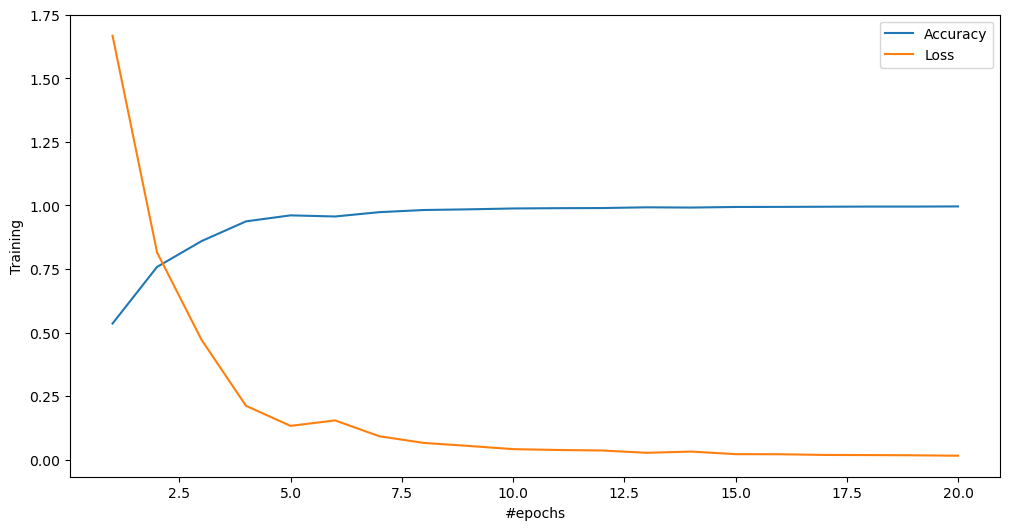

In [25]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

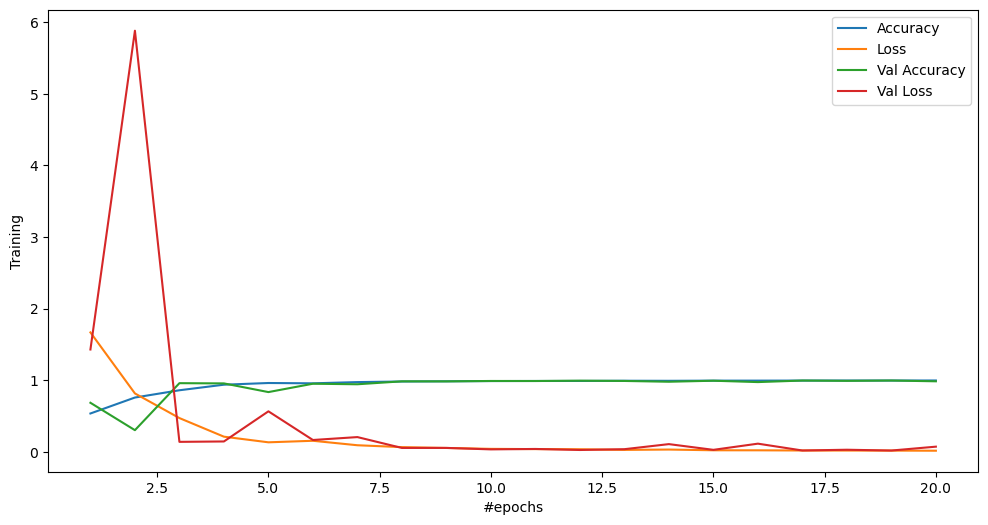

In [31]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Val Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Val Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

In [26]:
pred = np.argmax(model.predict(X_test), axis = 1)

458/458 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


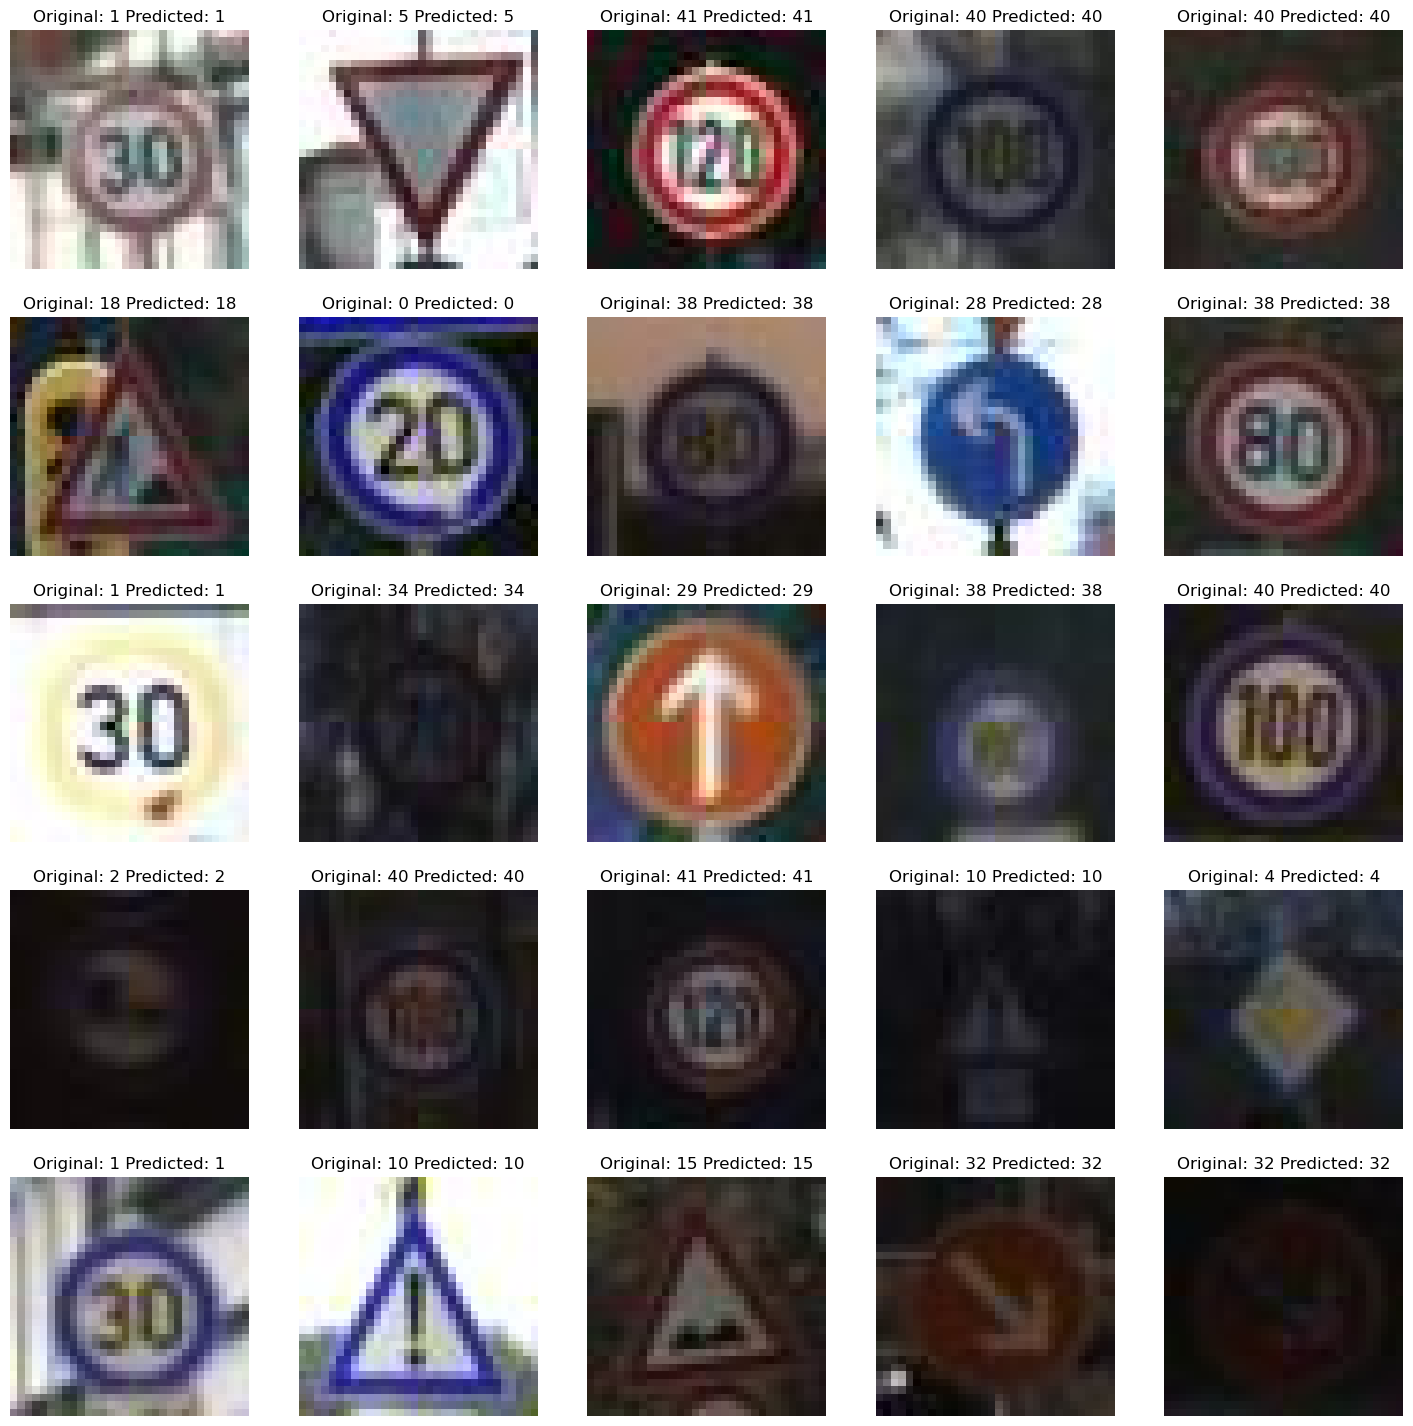

In [37]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))